# 2 Data processing
In this section of the notebook we will get the original training dataset provieded by the Happy Wale and we will transform, and reshape it to our needs.
Steps that will be performed in this script
- Load pickles
- Normalize images
- Generate positive pairs
- Generate negative pairs
- Shuffle all the data
- Split validation and training
- Pickle the data

We will start with the usual include section:

In [13]:
import math
import matplotlib.pyplot as plt
import random
import numpy as np
import os
from six.moves import cPickle as pickle
%matplotlib inline

In [2]:
train_balanced_dir_name = 'train_balanced'
path_train_balanced = os.path.join(os.path.abspath('../data'), train_balanced_dir_name)
pixel_depth = 255

# Definition of useful functions

In [3]:
def get_normalized_whale_images(pickle_file_path, verbose=False):
    ''' Input: file path to a .pickle
        Output: np vector containing all NORMALIZED and RESHUFFLED images of that pickle.'''
    # Open pickle file
    try:
        f = open(pickle_file_path, 'rb')
        _load = pickle.load(f)
        if verbose:
            print("Loaded file " + pickle_file_path)
        #Reshuffle numpy
        np.random.shuffle(_load)
        #Normalize image  to have approximately zero mean and standard deviation ~0.5 to make training easier down the road.
        _normalized = (_load - pixel_depth / 2) / pixel_depth
        del _load
        if verbose:
            print("Raw value  Example: {}".format( _load[0,:,:]))
            print("Normalized images Example: {}".format( _normalized[0,:,:]))
        f.close() 
        del f
    except Exception as e:
        print('Unable to save data to', pickle_file_path, ':', e)
        raise
        
    return _normalized

def generate_positive_pairs( pickle_file_path, verbose = False ):
    ''' Input: same_id_container -> np containing all images to be paired together 
        Output: X1, X2 = Two vectors containing half of the images each
                Y = Vector with labels (1) because same id
    '''    
    same_id_container = get_normalized_whale_images(pickle_file_path)
    #Evaluate nr of pairs that will be produced from given image list
    _entries = same_id_container.shape[0]
    if ( _entries% 2 != 0):  #Not an even number
        _entries -= 1 #Setting even images to process
        if verbose:
            print("Parsing {} number of pairs from a dataset of size {}.".format(_entries, whale_id_images.shape[0]))
            
    #Ensure _entries is an even number before progressing
    assert(_entries% 2 == 0)
    
    #Creating Arrays of sixe Half the dataset
    #_X1 = np.ndarray(shape = ( _entries/2 , DATASET_HEIGHT, DATASET_WIDTH))
    #print(_X1.shape)
    #_X2 = np.ndarray(shape = ( _entries/2 , DATASET_HEIGHT, DATASET_WIDTH))
    # Labesl all 1 because they are pairs from same ID
    _Y  = np.ones(_entries/2,dtype=int)
    
    #Getting indexes for X1 and X2
    _aux = np.arange(_entries)
    _x1_idx = _aux[ 0 : (_entries/2) ]
    _x2_idx = _aux[ (_entries/2) : _entries ]
    #X1 will contain 1st half of images
    _X1 = same_id_container[_x1_idx, :, :]
    #X2 wil contain 2nd half of images
    _X2 = same_id_container[_x2_idx, :, :]
    if verbose:
        print("final shape of X1: {}; of X2: {}; of Y: {}".format(_X1.shape, _X2.shape, _Y.shape) )
    
    return _X1, _X2, _Y

def generate_all_positive_pairs(pickle_paths):
    
    _X1_list = []
    _X2_list = []
    _Y_list = []
    
    for ix ,pickle_path in enumerate(pickle_paths):
        x1,x2,y = generate_positive_pairs(pickle_path)
        _X1_list.append(x1)
        _X2_list.append(x2)
        _Y_list.append(y)

    dataX1 = np.concatenate(_X1_list,axis=0)
    dataX2 = np.concatenate(_X2_list,axis=0)
    labels = np.concatenate(_Y_list,axis=0)
    
    return dataX1, dataX2, labels

def generate_pickle_list(root_path):
    
    #Make sure the path exist before executing the next steps.
    if not os.path.exists(root_path):
        raise ValueError("Path {} idoes not exist.".format(root_path) )
     
    # get all files' and folders' names in the current directory
    _filenames= os.listdir(root_path) 
    _sub_folders = []
    # loop through all the files and folders and check whether the current object is a folder or not
    
    for filename in _filenames: 
        _path = os.path.join(os.path.abspath(root_path), filename)
        # if it is a directory add it to subdirectories list
        if os.path.isdir(_path): 
            _path = os.path.join(os.path.abspath(_path), filename+'.pickle')
            #print(_path)
            if (os.path.isfile(_path)):
                _sub_folders.append(_path)
                
    return _sub_folders
                
def generate_all_negative_pairs(pickle_paths):
    
    #Load all the pickle images
    data_list = []
    label_list = []
    #print(_sub_folders[0])
    #print(len(_sub_folders))
    #print(data.shape)
    for ix ,pickle_path in enumerate(pickle_paths):
        norm_whale_images = get_normalized_whale_images(pickle_path)
        data_list.append(norm_whale_images)
        label_list.append(ix*np.ones((norm_whale_images.shape[0],), dtype=int))

    data = np.concatenate(data_list,axis=0)
    labels = np.concatenate(label_list,axis=0)
    del data_list[:]
    del label_list[:]
    
    print("Data is using %d bytes" % (data.size * data.itemsize))
    print("Labels is using %d bytes" % (labels.size * labels.itemsize))
    #del data_list
    #del label_list
        
    print(data.shape)
    print(labels.shape)
    
    #Reshuffle data randomly
    permutation = np.random.permutation(labels.shape[0])
    data = data[permutation,:,:]
    labels = labels[permutation]
    
    index = 0
    up_limit = (labels.shape[0]/2)*2+2*(labels.shape[0]%2-1)
    print(up_limit)
    
    padd = 10
    while index < up_limit:
        if(labels[index] == labels[index+1]):
            print('Image '+str(2*index)+' and '+str(2*index+1)+' are the same')
            permutation = np.arange(labels.shape[0]) 
            np.random.shuffle(permutation[index:min(up_limit,index+padd)])
            data = data[permutation,:,:]
            labels = labels[permutation]
            
        else:
            index += 2
            
    perm_X1 = np.arange(up_limit/2)*2
    perm_X2 = np.arange(up_limit/2)*2+1
    
    _X1 = data[perm_X1,:,:]
    _X2 = data[perm_X2,:,:]
    _Y = np.zeros(perm_X1.shape[0],dtype=int)
            
    return _X1, _X2, _Y

## Run the functions to generate pairs 

In [4]:
pickle_paths = generate_pickle_list(path_train_balanced)    
print("Create paths, {} in total".format(len(pickle_paths)))
px1, px2, py = generate_all_positive_pairs(pickle_paths)
print("Create generate_all_positive_pairs, {} in total".format(py.shape[0]))
nx1, nx2, ny = generate_all_negative_pairs(pickle_paths)
print("Create all_negative_pairs, {} in total".format(ny.shape[0]))

finalX1 = np.concatenate((nx1,px1), axis=0)
finalX2 = np.concatenate((nx2,px2), axis=0)
finalY = np.concatenate((ny,py), axis=0)

del nx1, nx2, ny, px1, px2, py
print("Final")
print(finalX1.shape)
print(finalX2.shape)
print(finalY.shape)

permutation = np.random.permutation(finalX1.shape[0])

finalX1 = finalX1[permutation,:,:]
finalX2 = finalX2[permutation,:,:]
finalY = finalY[permutation]

Create paths, 4251 in total
Create generate_all_positive_pairs, 9133 in total
Data is using 532829440 bytes
Labels is using 147680 bytes
(18460, 44, 82)
(18460,)
18458
Image 7208 and 7209 are the same
Image 14152 and 14153 are the same
Image 18616 and 18617 are the same
Image 24228 and 24229 are the same
Create all_negative_pairs, 9229 in total
Final
(18362, 44, 82)
(18362, 44, 82)
(18362,)


In [8]:
val_percentage = 0.15

val_threshold = int(finalX1.shape[0] * 0.85)
_aux = np.arange(finalX1.shape[0])
idx_train = _aux[ 0 : val_threshold ]
idx_val = _aux[ val_threshold : finalX1.shape[0]]

trainX1 = finalX1[idx_train,:,:]
trainX2 = finalX2[idx_train,:,:]
trainY  = finalY[idx_train]

print("Validation")
print(idx_train)
print(trainX1.shape)
print(trainX2.shape)
print(trainY.shape)

valX1 = finalX1[idx_val,:,:]
valX2 = finalX2[idx_val,:,:]
valY  = finalY[idx_val]

print("Validation")
print(idx_val)
print(valX1.shape)
print(valX2.shape)
print(valY.shape)

total = trainX1.shape[0] + valX1.shape[0]
print("Total: {}, Train {}% , Val {} %".format(total \
                                              , 100.0 * trainX1.shape[0] / total \
                                              , 100.0 * valX1.shape[0] / total))

Validation
[    0     1     2 ... 15604 15605 15606]
(15607, 44, 82)
(15607, 44, 82)
(15607,)
Validation
[15607 15608 15609 ... 18359 18360 18361]
(2755, 44, 82)
(2755, 44, 82)
(2755,)
Total: 18362, Train 84.9961877791% , Val 15.0038122209 %


## Do some Checks on dataset

In [9]:
print("Final X1 shape : {}".format(finalX1.shape))
print("Final X2 shape : {}".format(finalX2.shape))
print("Final Y shape : {}".format(finalY.shape))

assert( (finalX1.shape[0] == finalX2.shape[0] == finalY.shape[0]) )
assert( (finalX1.shape[1] == finalX2.shape[1]) )
assert( (finalX1.shape[2] == finalX2.shape[2]) )

Final X1 shape : (18362, 44, 82)
Final X2 shape : (18362, 44, 82)
Final Y shape : (18362,)


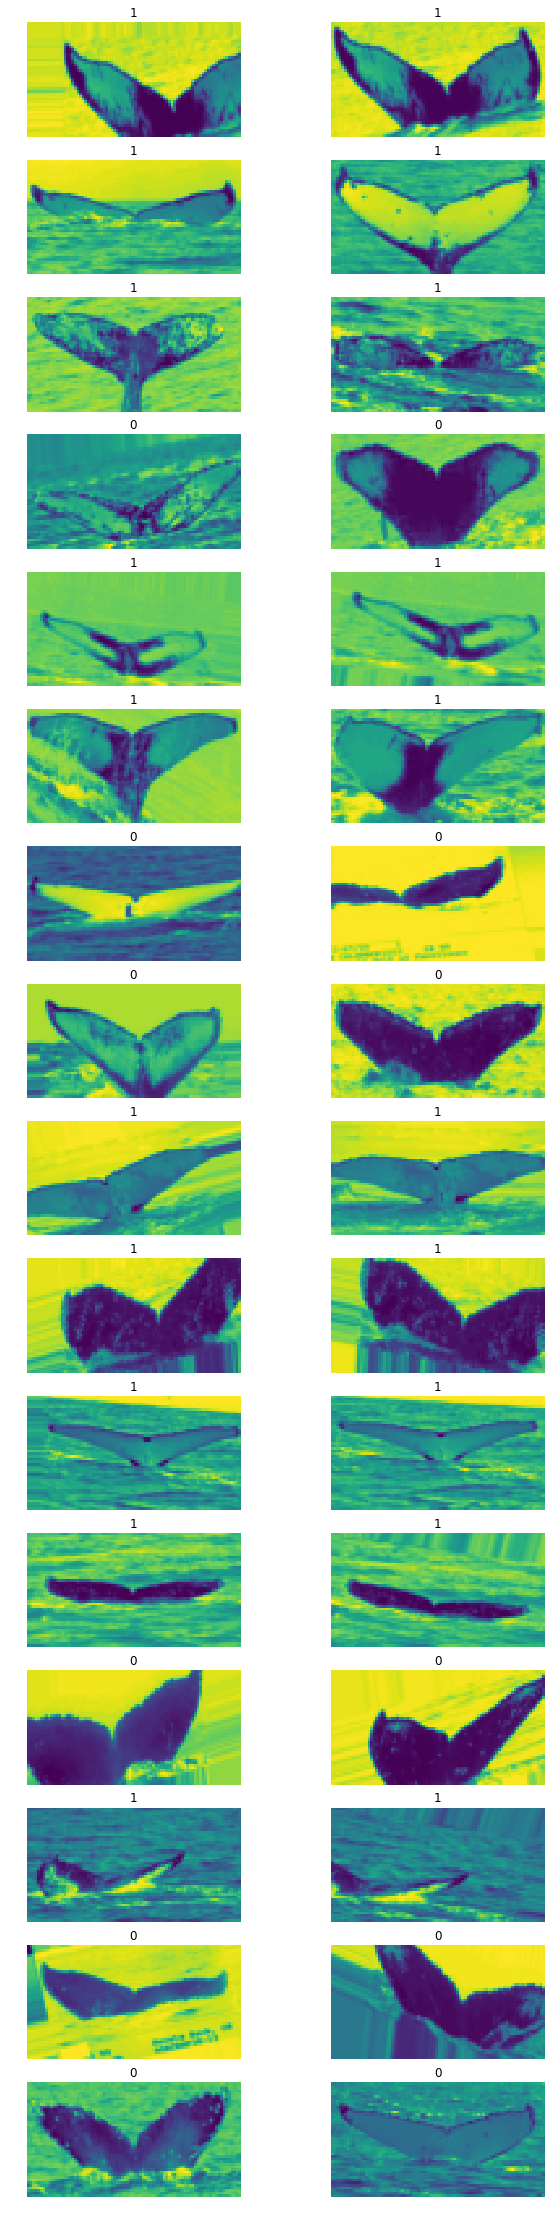

In [14]:
def disp_sample_dataset(dataset1, dataset2, labels, title=None):
    fig = plt.figure(figsize=(10,40))
    if title: fig.suptitle(title, fontsize=16, fontweight='bold')
    items = random.sample(range(len(labels)), 16)
    for i, item in enumerate(items):
        plt.subplot(16, 2, 2*i + 1)
        plt.axis('off')
        plt.title(str(labels[item]))
        plt.imshow(dataset1[item])
    for i, item in enumerate(items):
        plt.subplot(16, 2, 2*i + 2)
        plt.axis('off')
        plt.title(str(labels[item]))
        plt.imshow(dataset2[item])
    plt.show()
    
disp_sample_dataset(finalX1, finalX2, finalY)

## Save Final Dataset before proceed into CONVNET

In [15]:
pickle_file = os.path.join("../data", 'Siamese_dataset.pickle')

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_X1_dataset': trainX1,
        'train_X2_dataset': trainX2,
        'train_labels': trainY,
        'valid_X1_dataset': valX1,
        'valid_X2_dataset': valX2,
        'valid_labels': valY,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise
    
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size: {}'.format(statinfo.st_size) )

Compressed pickle size: 1060148888
